<p>&nbsp;</p>

## **Final Project: Song Clustering**

<p>&nbsp;</p>

<font size = "5">

Syracuse University  
IST 736 Text Mining  
Fall 2021

<p>&nbsp;</p>

## **Project Introduction**

<p>&nbsp;</p>

<font size = "5">

The music industry today is much different than it was in the past. A lot of things have changed. For example, advancements in the technology used for music production, shifts in consumer preferences, how the music sounds, the lyrical content, and even the way that people listen to music. These disruptions have led to the vast, diverse, and dynamic universe of music that we have available at our fingertips today.

Most recordings nowadays undergo digital enhancement before delivering the crispest audio quality to our ear drums. Artists have a variety of voice altering tools at their disposal such as autotune. Some modern day genres such as EDM or techno are created solely with the use of computer software. Consider the progression from tape players to CDs to IPods and now music streaming services over the internet.

In a previous project that I did on the topic of music, I studied various audio features about songs with an emphasis on predicting song popularity. In this project, I will be building on that but with a focus on song lyrics. And rather than trying to build a supervised machine learning model, the objective here is to model songs in an unsupervised fashion.

Here is what is on the docket. I will start off with some background on the data collection process. I will then go through the run-of-the-mill, but important process of examining the data and performing checks on the data. From there, I will do some exploratory data analysis and feature engineering before clustering the songs with a k-nearest-neighbors algorithm. I hope that you enjoy the project as much as I enjoyed creating it!

<p>&nbsp;</p>

### **Data Collection Process Overview**

<p>&nbsp;</p>

<font size = "5">

One of the major limitations in my previous project was poor quality of data that hindered the results. I used a dataset from Kaggle that turned out to be heavily biased. In this project, I attempt to address this shortcoming by retrieving a better sample of songs. My approach is to randomly sample songs from Spotify via their API. This should result in a better representation of the population of songs.

I researched if there was a way to get a random song from the Spotify API, but unfortunately, there is not a straight forward way to do it. But after jumping through some internet hoops (thank you Stack Overflow and others), I was able to figure out a way. It ends up being more pseudo random but still far more genuine than taking any kind of prebuilt playlist.

In addition to using random sampling to gather a diverse and realistic portfolio of songs, I also wanted to make sure that an equal share of songs were distributed at each point in time. This is important for my analysis since one of the aspects I will be studying is how music has changed over time. The Spotify API allows filtering by a year or range of years which allows me to maintain a uniform distribution of songs over time.

A couple more notes on the data collection process. In the diagram below, I have pointed out that there are varying degrees of the chance of failure at different stages. In the first two stages, there is virtually no chance of failure. The following two stages are where failure is most likely to occur. This is because first of all, not every song that exists on Spotify will also exist on Genius. So, after a song is sampled from Spotify, if the song is not found on Genius, then a new song is sampled. Another possible point of failure is if the artist name on Spotify is not an exact match with the artist name on Genius. Thus, even if there are minor differences in the artist name, a new song is sampled. But I anticipate this to be a relatively trivial percentage of cases. And while yes, this adds a layer of restriction, it also ensures a greater level of veracity of the data. One last thing. Each song (a) must be in english and (b) must be greater than 50 characters in length.

All of the code that was used for collection of data can be found in the appendex section.

<p>&nbsp;</p>

<img src = "data_collection_process_diagram.png" width = 500 height = 750 />

<p>&nbsp;</p>

### **Import Packages**

<p>&nbsp;</p>

<font size = "5">

Without further ado, lets dive into the project. As I usually do in my projects, I will start off by loading some packages and running some other setup related code.

<p>&nbsp;</p>

In [45]:
# Import standard packages
import pandas
import numpy
import nltk
import re
import gensim
import pyLDAvis

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc("axes", labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick", labelsize = 12)

# Additional imports
from itertools import chain
from textblob import TextBlob
from wordcloud import STOPWORDS

# For running LDA
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import pyLDAvis.sklearn as LDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn as LDAvis
import pyLDAvis.gensim_models

# Sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

<p>&nbsp;</p>

### **Import Data**

<p>&nbsp;</p>

<font size = "5">

The song data was collected separately and saved in a csv file. The code below assumes the file is saved in the current working directory.

<p>&nbsp;</p>

In [2]:
# Import data
song = pandas.read_csv("song_master_v3.csv")

<p>&nbsp;</p>

### **Look at the Data**

<p>&nbsp;</p>

<font size = "5">

Lets get familiar with the data, including how many rows and columns there are, taking a peek at the first 5 observations, checking the data types, summarizing the features, checking if there are any missing values, etc.

<p>&nbsp;</p>

In [3]:
# Print out the shape of the dataframe
print(song.shape)

(10000, 27)


In [4]:
# Display the top 5 observations
song.head()

,SongId,SpotifyUrl,SongName,ArtistName,ReleaseDate,ReleaseDatePrecision,DurationMs,Danceability,Energy,Key,...,Tempo,TimeSignature,Popularity,GeniusUrl,AnnotationCount,LyricsState,PageViews,SongLyrics,Attempts,CollectionTime
0,4EQIq1j1tAmK5y66a8qWtm,https://open.spotify.com/track/4EQIq1j1tAmK5y6...,Girl It's Over,Jagged Edge,2001-07-03,day,268800,0.652,0.581,6,...,119.941,4,37,https://www.genius.com/Jagged-edge-girl-its-ov...,1,complete,NaN,"[Verse 1]\nBaby, you can leave, you can leave,...",1.0,6.791037
1,1fKyowEioOTE2u8fQUk3oR,https://open.spotify.com/track/1fKyowEioOTE2u8...,We Both Know Which One Of Us Was Wrong,Jerry Lee Lewis,1972-01-01,day,217920,0.560,0.531,0,...,122.153,4,5,https://www.genius.com/Jerry-lee-lewis-we-both...,1,complete,NaN,Well I hear through the grapevines that your b...,4.0,7.284430
2,2K5laBSa5jVN1R7WBWC1ZX,https://open.spotify.com/track/2K5laBSa5jVN1R7...,Rhymes Of An Hour,Mazzy Star,1996-10-29,day,252773,0.561,0.167,7,...,77.879,3,40,https://www.genius.com/Mazzy-star-rhymes-of-an...,1,complete,5073.0,[Verse 1]\nCannot hear what you're saying\nCou...,5.0,8.320040
3,6ipchpEd2qj362S7RHEiBw,https://open.spotify.com/track/6ipchpEd2qj362S...,Oh Nina,The Muffs,1995-04-07,day,158666,0.231,0.986,7,...,175.791,4,32,https://www.genius.com/The-muffs-oh-nina-lyrics,1,complete,NaN,Oh Nina from Pasadena\nYou wanna see her\nAnd ...,6.0,12.038627
4,6y1MiuB3zS74YHMlvZxwdY,https://open.spotify.com/track/6y1MiuB3zS74YHM...,It's Still Rock & Roll to Me - Live at Madison...,Billy Joel,2006-06-13,day,206466,0.316,0.917,0,...,137.847,4,26,https://www.genius.com/Billy-joel-its-still-ro...,13,complete,45566.0,[Verse 1]\nWhat's the matter with\nThe clothes...,1.0,2.583468


In [5]:
# Show the data types for each column
song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SongId                10000 non-null  object 
 1   SpotifyUrl            10000 non-null  object 
 2   SongName              10000 non-null  object 
 3   ArtistName            10000 non-null  object 
 4   ReleaseDate           10000 non-null  object 
 5   ReleaseDatePrecision  10000 non-null  object 
 6   DurationMs            10000 non-null  int64  
 7   Danceability          10000 non-null  float64
 8   Energy                10000 non-null  float64
 9   Key                   10000 non-null  int64  
 10  Loudness              10000 non-null  float64
 11  Mode                  10000 non-null  int64  
 12  Speechiness           10000 non-null  float64
 13  Acousticness          10000 non-null  float64
 14  Instrumentalness      10000 non-null  float64
 15  Liveness            

<p>&nbsp;</p>

<font size = "5">

The data types appear to be correct which is good so no adjustment needed there. The only column which has some nulls is the PageViews column. PageViews was one of the attributes that was collected from Genius. The reason for the nulls is because those songs did not have any page views. I am not too concerned about this because I will not be using the PageViews column. 

<p>&nbsp;</p>

In [6]:
# Summarize the numeric features
song.select_dtypes([numpy.number]).describe()

,DurationMs,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,TimeSignature,Popularity,AnnotationCount,PageViews,Attempts,CollectionTime
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,4.353000e+03,10000.000000,10000.000000
mean,2.371570e+05,0.562126,0.625410,5.259500,-8.701696,0.713000,0.089876,0.264380,0.058331,0.20326,0.511523,121.209987,3.915300,37.227500,3.577500,9.592761e+04,2.927800,5.059102
std,8.384111e+04,0.170815,0.235059,3.578469,4.064098,0.452384,0.103108,0.296434,0.177109,0.17758,0.245890,29.613048,0.365704,15.271577,6.776768,2.872781e+05,2.329577,4.098950
min,3.013300e+04,0.000000,0.001100,0.000000,-29.282000,0.000000,0.000000,0.000001,0.000000,0.01010,0.000000,0.000000,0.000000,0.000000,0.000000,5.003000e+03,1.000000,1.239848
25%,1.882265e+05,0.446000,0.455000,2.000000,-11.189500,0.000000,0.033400,0.016500,0.000000,0.09450,0.312000,97.444750,4.000000,26.000000,1.000000,9.840000e+03,1.000000,2.587538
50%,2.265465e+05,0.569000,0.652000,5.000000,-7.865500,1.000000,0.046200,0.132000,0.000020,0.13100,0.512500,119.982000,4.000000,37.000000,1.000000,2.307700e+04,2.000000,3.863052
75%,2.697362e+05,0.685000,0.821000,9.000000,-5.640000,1.000000,0.091800,0.456000,0.003440,0.25900,0.710000,140.033000,4.000000,48.000000,4.000000,7.252300e+04,4.000000,6.186486
max,1.388720e+06,0.976000,0.999000,11.000000,1.789000,1.000000,0.954000,0.996000,0.998000,1.00000,0.984000,217.943000,5.000000,90.000000,333.000000,9.028232e+06,24.000000,48.906709


<p>&nbsp;</p>

<font size = "5">

The numeric features in this dataset consist of the audio features that were gathered from the Spotify API along with a couple others. For a description on what these mean please refer to the appendix. The main purpose for these is because they will be used for clustering, but we will get to that later.

<p>&nbsp;</p>

In [7]:
# Summarize the character features
song.select_dtypes([object]).describe()

,SongId,SpotifyUrl,SongName,ArtistName,ReleaseDate,ReleaseDatePrecision,GeniusUrl,LyricsState,SongLyrics
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,9254,9254,8913,4309,3442,3,8998,1,8994
top,1RsxUuB1Q5OdseLpHMBkEN,https://open.spotify.com/track/1edP9mOIcf8lDzl...,The Way I Am,Johnny Cash,2006-01-01,day,https://www.genius.com/Metallica-seek-and-dest...,complete,[Intro]\nAlright\n[Verse 1]\nWe're scanning th...
freq,4,4,5,34,82,8298,9,10000,9


<p>&nbsp;</p>

<font size = "5">

Some of the character features in this dataset are for informational purposes, such as the song id, the spotify url, song name, etc. Others will serve an analytical purpose such as the release date and the song lyrics which we will see more of in a little bit. Again, if you would like a description of these fields, please refer to the appendix.

<p>&nbsp;</p>

<font size = "5">

One thing that I noticed is that not all of the songs are unique based on the SongId column. This was not what I was expecting because I thought I had coded the data collection process to only accept unique songs. Nonetheless, there are only 746 duplicates, which is less than 10% of the data, so I am not too concerned about removing them, which I will do now.

<p>&nbsp;</p>

In [8]:
# Remove the duplicate song ids in the song dataframe
print("\n"); print("Number of Songs Before Removing Duplicates: ", len(song))
song = song.drop_duplicates(subset = ["SongId"], keep = "first")
print("Number of Songs After Removing Duplicates: ", len(song))



Number of Songs Before Removing Duplicates:  10000
Number of Songs After Removing Duplicates:  9254


<p>&nbsp;</p>

<font size = "5">

Similar to the song ids from Spotify not being unique, there are also some songs that refer to the same link for Genius. There are 2 potential situations that I think this problem arised from.

(a) The same song but a different version of it (for example live, remastered, etc.) was collected during the data collection process by chance from the Spotify API, and when searching for that song on Genius it led to the same page.

(b) The wrong song appeared at the top of the search results on Genius. For example, when searching for a song on Genius, if the song does not exist, it might return other songs by the artist in the search results. Due to the way the data collection process was coded, it will take the first search result where the artist is a match. When looking at the number of unique artists in the data, about half or so are unique, which leads me to believe that this is the most likely case.

I would also expect that the song lyrics field has the same distinct count as the genius url, but there are several lyrics that are duplicates even though they have a different genius url. Unfortunately with these, there is no way to know which url is the right url. Therefore, I will remove these duplicates without keeping.

<p>&nbsp;</p>

In [9]:
# Remove the duplicate genius urls and genius lyrics in the song dataframe
print("\n"); print("Number of Songs Before Removing Duplicates: ", len(song))
song = song.drop_duplicates(subset = ["GeniusUrl"], keep = False)
song = song.drop_duplicates(subset = ["SongLyrics"], keep = False)
print("Number of Songs After Removing Duplicates: ", len(song))



Number of Songs Before Removing Duplicates:  9254
Number of Songs After Removing Duplicates:  8761


<p>&nbsp;</p>

### **Song Lyrics Preprocessing**

<p>&nbsp;</p>

<font size = "5">

Another issue is that the song lyrics are unprocessed which you can tell by looking at the SongLyrics column in the glimpse of the top 5 observations from earlier. There are a few things that need to be done to clean up the lyrics.  

**(a) remove annotations**

On Genius.com, annotations in brackets are often made which separate the parts of a song such as verse, chorus, bridge, intro, outro, etc. They also sometimes identify the artist singing that part of the song, for example, sometimes there is a featured artist. I do not want these annotations in this analysis since I am focused on the lyrical content for entire songs.

**(b) remove punctuation**

I decided that I will be removing punctuation in the lyrics. Typically there is little punctuation to begin with. From my observation, this mainly affects conjuctions, which as a result, will be treated as their own word. 

**(c) remove line breaks and extra whitespace**

For the purposes of this analysis, I will be removing line breaks because the lyrics for a song are treated as one consecutive string. The reason that I kept the line breaks there in the first place is because in a future analysis if someone wanted to take a deeper dive on the lyrics it could potentially be insightful to include the lines as part of the analysis.

**(d) make text all lowercase**

I decided to make the text all lowercase because I do not want to differentiate words by their capitalization. In a natural language processing application, the capitalization may be wanted for contextual purposes, but in this case I am simply looking at the words.

<p>&nbsp;</p>

<font size = "5">

Here is an example of what the lyrics look like in their unprocessed state. I truncated the example at 500 characters to keep it from taking up too much room.

<p>&nbsp;</p>

In [10]:
# Show a sample of the song lyrics
print("\n"); print(song.SongLyrics[100][0:500])



[Verse 1: Cyndi Lauper]
Here I am
Just like I said I would be
I'm your friend
Just like you think it should be
Did you think I would stand here and lie?
While our moment was passing us by
Oh, while I'm here
[Chorus: Cyndi Lauper & The Bangles]
Waiting for your change of heart
It just takes a beat
To turn it around
Yes, I'm waiting for your change of heart
At the edge of my seat
Please turn it around
[Verse 2: Cyndi Lauper]
Days go by
Leaving me with a hunger
I could fly
Back to when we were youn


<p>&nbsp;</p>

<font size = "5">

Now I will peform a cleaning operation using regex with the sub function from the re package and the strip / lower methods for string classes and print out the result.

<p>&nbsp;</p>

In [ ]:
# Define a cleaning function
def clean(text):
    text = re.sub("\[.*\]", "", text)           # Remove anything in brackets
    text = re.sub("[^\w\s]", "", text)          # Remove punctuation and special characters
    text = re.sub("\n", " ", text)              # Remove line breaks
    text = re.sub("\s\s+", " ", text).strip()   # Remove excess white space
    return text.lower()                         # Return the lowercase text

In [12]:
# Show the cleaning function in action
print("\n"); print(clean(song.SongLyrics[100]))



here i am just like i said i would be im your friend just like you think it should be did you think i would stand here and lie while our moment was passing us by oh while im here waiting for your change of heart it just takes a beat to turn it around yes im waiting for your change of heart at the edge of my seat please turn it around days go by leaving me with a hunger i could fly back to when we were younger when adventures like cars we would ride and the years lied ahead still untried while i stand here waiting for your change of heart it just takes a beat to turn it around yes im waiting for your change of heart at the edge of my seat please turn it around turn it around around around turn it around around around turn it around blind leading blind never feel the laughter search through time nothing reveals the answer if its truth that youre looking to find and its nowhere outside of your mind when i bide my time waiting for your change of heart it just takes a beat to turn it arou

<p>&nbsp;</p>

<font size = "5">

The cleaned version looks how I would expect it to. In the following line of code, I will replace all of the unprocessed lyrics with the cleaned lyrics in the song dataframe.

<p>&nbsp;</p>

In [13]:
# Overwrite the unprocessed lyrics with cleaned lyrics
song["SongLyrics"] = [clean(lyric) for lyric in song.SongLyrics]

<p>&nbsp;</p>

### **Distribution of Song Years**

<font size = "5">

Now I will take a look at the distribution of the song release dates. Recall that the idea in the experimental design was that this should be uniform.

<p>&nbsp;</p>



count    8761.000000
mean     1998.935852
std        14.655208
min      1970.000000
25%      1988.000000
50%      2001.000000
75%      2012.000000
max      2021.000000
Name: Year, dtype: float64 



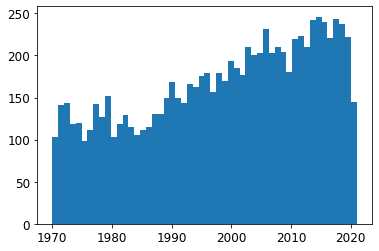

In [14]:
# Display a histogram of the release dates
song["Year"] = [int(date[0:4]) for date in song.ReleaseDate]   # Extract the year as a new column
print("\n"); print(song["Year"].describe(), "\n")              # Summary statistics for the year column
plt.hist(song["Year"], bins = 52); plt.show()                  # Histogram plot for the year column

<p>&nbsp;</p>

<font size = "5">

There appears to be some recency bias. As you can see in the histogram, starting at about 1990 or so, the number of songs in each year starts to gradually increase. This is due to how I designed the data collection process. To ensure that lyrics were gathered for every song, I designed the code to repeatedly sample until a song with lyrics was found. I suspect that older songs are less likely to have lyrics available on Genius, which explains why we are seeing this pattern.

<p>&nbsp;</p>

### **Undersampling to Balance Song Years**

<font size = "5">

One remedy for this is to undersample the data. I debated whether or not to do this, but I decided that it would be for the better. The downside to this approach is loss of information. The upside is that it is the safest bet to minimize bias. When it comes down to it, I would rather err on the side of caution. Plus, I believe that even with the undersampling there is still sufficient data.

<p>&nbsp;</p>

In [15]:
# Undersample 125 observations for every year 1990-2021
print("\n"); print("Number of Songs Before Undersampling: ", len(song))
notsampled = song[song.Year < 1990]
sampled = pandas.DataFrame(columns = song.columns)
for year in range(1990, 2022):
    subset = song[song.Year == year].sample(n = 125, random_state = 42)
    sampled = pandas.concat([subset, sampled]).reset_index(drop = True)
song = pandas.concat([notsampled, sampled]).reset_index(drop = True)
print("Number of Songs After Undersampling: ", len(song))



Number of Songs Before Undersampling:  8761
Number of Songs After Undersampling:  6466


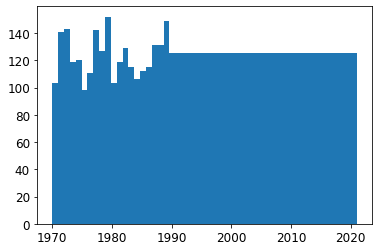

In [16]:
# Show the histogram again after the undersampling
print("\n"); plt.hist(song["Year"], bins = 52); plt.show()

### **Distribution of Song Lyrics Length**

<font size = "5">

The next area I will explore is the distribution of the lengths of the song lyrics in terms of number of words. For one, I am curious as to what this distribution will look like, but this is also precautionary to make sure that there is nothing unusual going on. In the following code, I will use the word_tokenize function from the nltk package to tokenize each observation of song lyrics, count the number of tokens, pack all of that into a list, and then use the list to plot histogram.

<p>&nbsp;</p>



count    6466.000000
mean      298.816579
std       212.181963
min         0.000000
25%       173.000000
50%       247.000000
75%       354.000000
max      6407.000000
Name: LyricLength, dtype: float64 



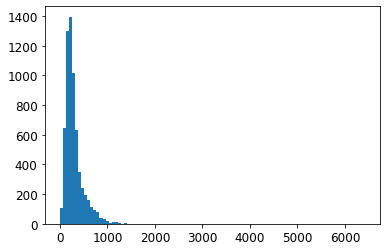

In [17]:
# Show a distribution of the lengths of song lyrics
song["LyricLength"] = [len(nltk.word_tokenize(lyric)) for lyric in song.SongLyrics]   # Extract the length as a new column
print("\n"); print(song["LyricLength"].describe(), "\n")                              # Summary statistics for the year column
plt.hist(song["LyricLength"], bins = 100); plt.show()                                 # Histogram plot for the year column

### **Remove Really Short and Really Long Songs**

<font size = "5">

The number of words per song is normally distributed with the average around 299. As I suspected, however, this chart shows that there are some outliers on both sides of the distribution.

I reviewed these extremes to decide whether it makes sense to keep them or not. I found out that anything with less than 50 or so words tends to be more of an instrumental based song. Anything with greater than 800 or so words tends to be an annotated version of the song. This just means that there are embedded explanations of the meaning of the lyrics that unavoidably got captured during the web scraping process.

Thus, based on my investigation of outliers, I find that it is justifiable to remove them. The outliers represent things that I am not interested in for this analysis. Here are the steps that I will be following to handle the outliers (and any annotated versions of lyrics that are not outliers)

**(a)** remove records where the genius url ends with "annotated" (this is how annotated versions of lyrics are identified)  
**(b)** use the percentile method to remove song lyrics that have a number of words below the 2.5th percentile or above the 97.5th percentile

<p>&nbsp;</p>

In [18]:
# Remove outliers for lyrics length
print("\n"); print("Number of Songs Before Removing Outliers: ", len(song))
lengths = song["LyricLength"].copy()    # Save a copy of the lyric lengths column
lower = lengths.quantile(0.025)         # Save the 2.5th quantile
upper = lengths.quantile(0.975)         # Save the 97.5th quantile
song = song[song.LyricLength > lower]   # Filter out records below the 2.5th quantile
song = song[song.LyricLength < upper]   # Filter out records above the 97.5th quantile
print("Number of Songs After Removing Outliers: ", len(song))



Number of Songs Before Removing Outliers:  6466
Number of Songs After Removing Outliers:  6138


In [19]:
# Remove any remaining annotated lyrics
print("\n"); print("Number of Songs Before Removing Annotated: ", len(song))
song["Annotated"] = ["annotated" in url for url in song.GeniusUrl]
song = song[song.Annotated == False]
print("Number of Songs After Removing Annotated: ", len(song))



Number of Songs Before Removing Annotated:  6138
Number of Songs After Removing Annotated:  6107


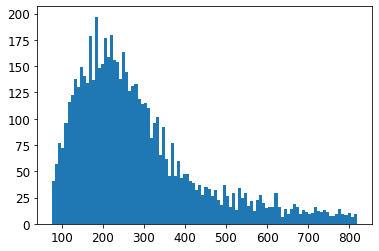

In [20]:
# Show the histogram again after removing the outliers
print("\n"); plt.hist(song["LyricLength"], bins = 100); plt.show()

<p>&nbsp;</p>

<font size = "5">

The new histogram looks much better after removing the outliers. But note that the distribution is skewed with a long right tail. This should not be a problem. It just means that there are disproportionally more songs that have more words than less words. After all this cleaning, the number of songs has reduced by almost 40%. But there are still over 6,000 songs that remain.

<p>&nbsp;</p>

### **Lyrical Content Over Time**

<font size = "5">

Let's take a look into some of these song lyrics and see what the artists are talking about. In the following code, I will look at the most frequently occuring words for songs in the 1970s and compare that to songs in 2010s. Note that based on my own observations I have defined a list of some stop words. Some of them are conjuctions without the apostrophe that do not get picked up by standard stop word lists, others are domain specific words that I found occur commonly across all songs, and some are just fragments of words that for some reason get split up by the tokenizer. 

<p>&nbsp;</p>

In [21]:
# Define the list of conjunction words
conjunctions = ["im", "dont", "youre", "cant", "ill", "ive", "aint", "theres", "youll", "youve",
"shes", "thats", "hes", "id", "didnt", "theyre", "wont", "lets", "whats"]

# Define the list of common words
commonwords = ["know", "got", "come", "well", "now", "go", "way", "will", "say", "take", "oh", "baby",
"yeah", "hey", "ya", "like", "want", "things", "ah", "let", "cause", "going", "ooh", "uh", "ho", "eh",
"ohohoh", "dhoh", "need", "comes", "coming", "wanna", "gonna", "gotta", "em","yes", "try"]

# Define the list of fragments
fragments = ["na", "gon", "wan", "la", "ta", "da", "ha", "dha"]

# Put them all together into mystopwords
mystopwords = conjunctions + commonwords + fragments

In [22]:
# Define a function for printing the top words for the lyrics
def top_words(lyrics_column, n_tokens):
    tokenlist = [nltk.word_tokenize(lyric) for lyric in lyrics_column]
    tokenlistflat = list(chain.from_iterable(tokenlist))
    stopped = [token for token in tokenlistflat if token not in STOPWORDS]
    stopped = [token for token in stopped if token not in mystopwords]
    print("\n"); print(nltk.FreqDist(stopped).most_common(n_tokens))

In [23]:
# Define a function for printing the top bigrams for the lyrics
def top_bigrams(lyrics_column, n_bigrams):
    tokenlist = [nltk.word_tokenize(lyric) for lyric in lyrics_column]
    tokenlistflat = list(chain.from_iterable(tokenlist))
    stopped = [token for token in tokenlistflat if token not in STOPWORDS]
    stopped = [token for token in stopped if token not in mystopwords]
    finder = nltk.BigramCollocationFinder.from_words(stopped)
    measures = nltk.collocations.BigramAssocMeasures()
    scored = finder.score_ngrams(measures.raw_freq)
    scorednew = [(bigram, round(freq * len(scored))) for bigram, freq in scored]
    print("\n"); print(scorednew[0:n_bigrams])

In [24]:
# Print out the top words for the 70s
print("\n"); print("Top Words in Song Lyrics in the 1970s")
top_words(song[(song.Year >= 1970) & (song.Year < 1980)].SongLyrics, 100)
top_bigrams(song[(song.Year >= 1970) & (song.Year < 1980)].SongLyrics, 15)



Top Words in Song Lyrics in the 1970s


[('love', 2857), ('time', 962), ('good', 621), ('little', 614), ('man', 600), ('right', 598), ('heart', 583), ('night', 569), ('day', 562), ('away', 542), ('tell', 536), ('feel', 515), ('life', 504), ('said', 491), ('girl', 487), ('world', 448), ('home', 444), ('mind', 372), ('long', 370), ('think', 367), ('old', 364), ('leave', 334), ('thing', 333), ('gone', 315), ('look', 308), ('song', 295), ('eyes', 282), ('sing', 274), ('people', 266), ('woman', 266), ('live', 258), ('better', 247), ('hand', 237), ('walk', 236), ('run', 235), ('dance', 234), ('days', 233), ('hold', 233), ('free', 232), ('hear', 231), ('stay', 218), ('face', 215), ('new', 214), ('rock', 214), ('place', 212), ('feeling', 209), ('hard', 208), ('lord', 205), ('sweet', 201), ('light', 199), ('loving', 196), ('soul', 195), ('tonight', 192), ('believe', 191), ('roll', 191), ('town', 187), ('inside', 181), ('sun', 180), ('wrong', 178), ('fool', 178), ('rain', 176), ('true', 169), 

In [25]:
# Print out the top words for the 21s
print("\n"); print("Top Words in Song Lyrics in the 2010s")
top_words(song[(song.Year >= 2010) & (song.Year < 2020)].SongLyrics, 100)
top_bigrams(song[(song.Year >= 2010) & (song.Year < 2020)].SongLyrics, 15)



Top Words in Song Lyrics in the 2010s


[('love', 1899), ('time', 1312), ('right', 961), ('tell', 898), ('nigga', 875), ('fuck', 873), ('feel', 850), ('life', 749), ('bitch', 665), ('shit', 658), ('low', 646), ('night', 627), ('man', 618), ('away', 607), ('think', 606), ('girl', 605), ('said', 544), ('good', 534), ('niggas', 521), ('day', 517), ('heart', 510), ('mind', 496), ('look', 479), ('world', 452), ('little', 411), ('better', 398), ('high', 397), ('hold', 395), ('home', 393), ('long', 389), ('money', 380), ('god', 378), ('eyes', 377), ('stay', 377), ('light', 353), ('head', 343), ('real', 327), ('live', 322), ('stop', 320), ('bad', 316), ('leave', 313), ('hear', 312), ('left', 310), ('inside', 309), ('run', 309), ('old', 308), ('talk', 307), ('gone', 305), ('friends', 305), ('bout', 303), ('fall', 300), ('hard', 297), ('new', 295), ('turn', 293), ('thing', 292), ('damn', 286), ('told', 283), ('came', 282), ('hope', 278), ('maybe', 274), ('hands', 274), ('boy', 273), ('ayy', 27

<p>&nbsp;</p>

<font size = "5">

In the 1970s, you can see that some of the most notable words include "love", "rock and roll", "feel", "friends", "heart", "life", "live", "song", "sing", "free". I think this seems like a pretty accurate depiction of the culture at that time. Historically speaking, the 1970s are generally seen as a happy time.
    
In the 2010s, some of the same words are seen, but there are also some new ones that appear. For example, words such as "tryna", "yo", "smoke", "party", and even some profanity words (sorry) are not words that would typically be found in songs in the 1970s. These are words that have emerged due to the rise of pop culture.
    
It is interesting to see that a lot of the top words are similar between the two decades, such as "love", "time", "man", "woman", "girl", which indicates that some of the themes in music have remained consistent throughout the years, and then there are unique words that characterize a particular period of time. 

<p>&nbsp;</p>

### **LDA Topic Modeling (What the Song is About)**

<font size = "5">

In the following section, I will use linear dirichlet allocation (LDA) to analyze the song lyrics. I do not have any predispositions in terms of what to expect for how many topics will be a good fit. My approach is to experiment with a different number of topics, experiment with different parameters, and then evaluate the perplexity scores.

<p>&nbsp;</p>

In [26]:
# Define a function to perform preprocessing
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and token not in mystopwords and token not in STOPWORDS:
            result.append(token)
    return result

In [27]:
# Use the preprocess function on the text
docs = song["SongLyrics"].map(preprocess)

In [28]:
# Create a dictionary containing word frequencies
dictionary = gensim.corpora.Dictionary(docs)

In [29]:
# Filter out tokens that appear in less than 15 docs or more than 30% of docs
dictionary.filter_extremes(no_below = 100, no_above = 0.20)

In [30]:
# For each doc, create a bag of words
bowcorpus = [dictionary.doc2bow(doc) for doc in docs]

In [31]:
# Create tfidf model object on bowcorpus
tfidfmodel = models.TfidfModel(bowcorpus)
tfidfcorpus = tfidfmodel[bowcorpus]

In [32]:
# Run the lda model
lda = LdaMulticore(bowcorpus, num_topics = 3, id2word = dictionary, passes = 10)

In [33]:
# Perplexity is a measure of how good the model is, lower the better
print("Perplexity: ", lda.log_perplexity(bowcorpus))

Perplexity:  -6.120133167698259


In [ ]:
# Save a vis to an html document to the current working directory
vis = pyLDAvis.gensim_models.prepare(lda, bowcorpus, dictionary)
pyLDAvis.save_html(vis, "lda_example.html")

In [35]:
# Save the words that make up the topics into a dictionary
# https://stackoverflow.com/questions/46536132/how-to-access-topic-words-only-in-gensim
topicdict = {'Topic_' + str(i): [token for token, score in lda.show_topic(i, topn = 30)] for i in range(0, lda.num_topics)}

<img src = "lda_pyvis_image.png" width = 1100 height = 750 />

<p>&nbsp;</p>

<p>&nbsp;</p>

<font size = "5">

What I found was that the number of topics that seems to be the best fit is 3 topics. The perplexity score is not that great, but as you can see from the visual of the LDA model above, each topic is relatively distinct, as indicated by the bubbles being farther away from eachother.

- Topic 1, in the bottom, has words such as "heart", "girl", "world" "good", "believe", "break" - this might resemble a topic that has to do with relationships.

- Topic 2, in the upper left, has words such as "little", "mind", "think", "rock", "dance" - it seems as though this topic is sort of like a music type of topic.

- Topic 3, in the upper right, has words such as "hear", "ride", "lord", "jesus", "heaven", "touch", "hell", "god" - it is pretty clear that this topic has to do with religion. 

<p>&nbsp;</p>

### **Add the LDA Topics as Features**

<p>&nbsp;</p>

<font size = "5">

What I will do next is add the topics from the LDA model as features in the dataset. So, since I got 3 LDA topics out of my LDA model, there will be 3 columns added to the dataset, one for each topic. The values will represent the number of hits the song had for that topic. I will iterate through every song, and iterate through every word in that song, and check if the word exists in each LDA topic. If the word exists, then the topic gets a +1.

<p>&nbsp;</p>

In [36]:
# Initiate empty lists for each topic to save results in
topic1 = []; topic2 = []; topic3 = []

# Iterate through every song lyric
for lyric in song.SongLyrics:

    # Tokenize the lyric
    tokens = nltk.word_tokenize(lyric)

    # Initiate empty variables to store results
    result1 = 0; result2 = 0; result3 = 0

    # Iterate through all of the tokens
    for token in tokens:

        # Test if the token is in topic 1
        test1 = token in topicdict["Topic_0"]
        if test1: result1 += 1

        # Test if the token is in topic 2
        test2 = token in topicdict["Topic_1"]
        if test2: result2 += 1

        # Test if the token is in topic 3
        test3 = token in topicdict["Topic_2"]
        if test3: result3 += 1

    # Append the results to the top level results
    topic1.append(result1); topic2.append(result2); topic3.append(result3)

In [37]:
# Add the 3 topics as columns to the song dataframe
song["Topic1"] = topic1
song["Topic2"] = topic2
song["Topic3"] = topic3

<p>&nbsp;</p>

<font size = "5">

Here is what that looks like. For example, the first song had 3 hits on Topic 1, 1 hit on Topic 2, and 5 hits on Topic 5. So this song touches a little bit on each of the topics. The second song had a large number of hits on Topic 2. It is not a perfect science but the idea is that this information will be useful for clustering the songs!

<p>&nbsp;</p>

In [39]:
# Show an example of what the columns look like
song[["SongName", "ArtistName", "Topic1", "Topic2", "Topic3"]].head()

,SongName,ArtistName,Topic1,Topic2,Topic3
0,We Both Know Which One Of Us Was Wrong,Jerry Lee Lewis,3,1,5
1,It Ain't Easy Comin' Down,Charlene,3,14,0
2,Knockin' On Heaven's Door,Eric Clapton,0,1,0
3,We Can Work It Out,Stevie Wonder,8,11,9
4,Two's Up,AC/DC,2,4,2


<p>&nbsp;</p>

### **Sentiment Analysis (Is the Song Happy or Sad?)**

<font size = "5">

Now I will do sentiment analysis of each song, which could also be useful for clustering, because it adds another aspect of the song that has not been captured yet. On the other hand, it could add confusion. Most genres have songs that are both positive and negative in sentiment, which means that the sentiment of a song might not be that informative afterall. Additionally, you could have a song that has a high audio valence (how positive a song sounds based on its audio features), but at the same time the lyrical content may have a negative sentiment.

<p>&nbsp;</p>

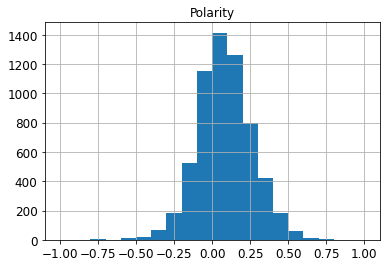

In [41]:
# Create textblob objects of the song lyrics
sentobjs = [TextBlob(lyric) for lyric in song.SongLyrics]

# Create list of the lyrics and their polarity scores
sentvals = [[lyric.sentiment.polarity, str(lyric)] for lyric in sentobjs]

# Create dataframe containing the polarity value and lyric
sentdf = pandas.DataFrame(sentvals, columns = ["Polarity", "Lyric"])

# Plot a histogram of the overall sentiment
sentdf.hist(bins = [-1, -.9, -.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0,
.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]); plt.show()

In [42]:
# Add the polarity scores as a feature
song["Sentiment"] = sentdf["Polarity"]

In [43]:
# Some came back as NA so change those to 0
song["Sentiment"] = song["Sentiment"].fillna(0)

<p>&nbsp;</p>

<font size = "5">

The polarity scores from text blob form a normal distribution centered around 0, as seen in the histogram above. It almost looks like a cauchy distribution with the steepness of the curve. Anecdotally, I feel like this is realistic because most songs have a blend of emotions and the highs and lows end up cancelling each other out. There are, however, songs that are more one sided but these songs occur less frequently.

<p>&nbsp;</p>

### **Song Audio Features (How the Song Sounds)**

<font size = "5">

The last thing I want to show before getting into the clustering is the distributions of the audio features. Recall from earlier that the audio features come from the Spotify API. Each audio feature reflects, in numerical terms, an aspect of how the song sounds. For a description of what each of the audio features mean please refer to the appendix.

<p>&nbsp;</p>

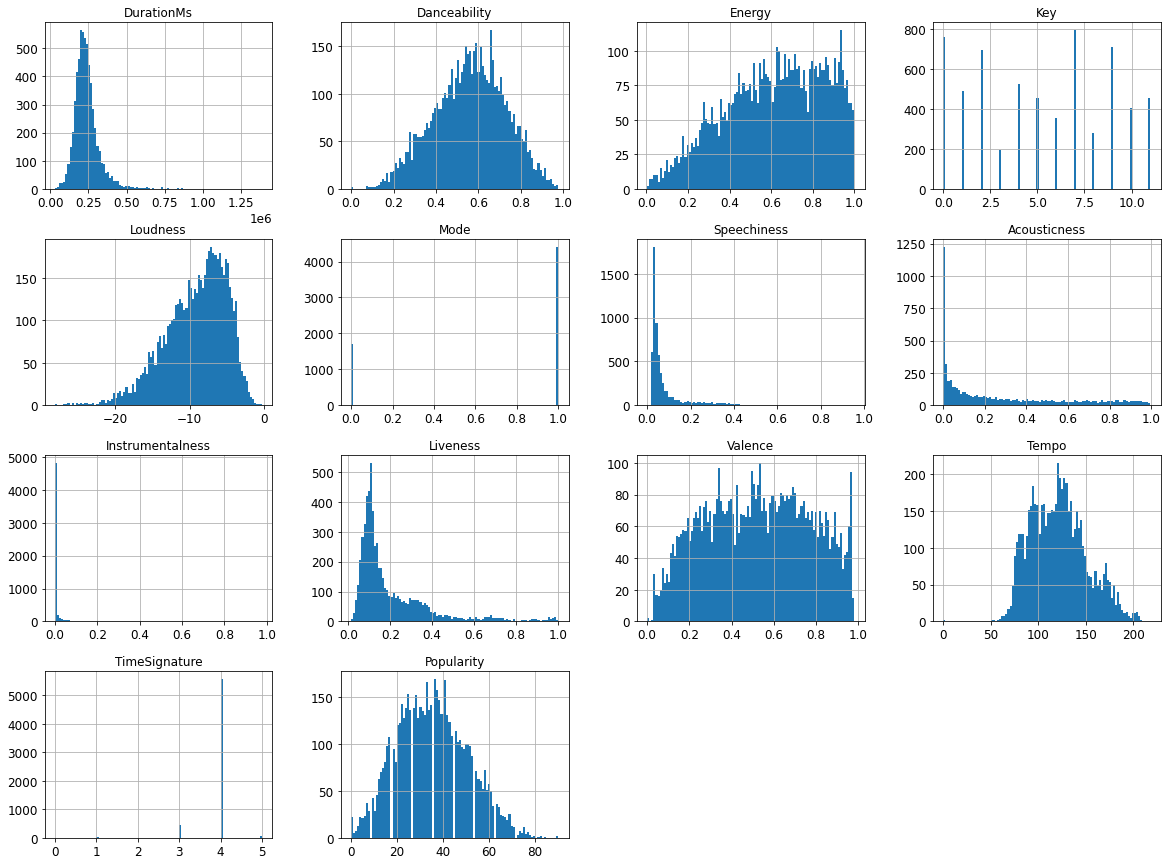

In [44]:
# View histograms for the audio features
audiofeats = ["DurationMs", "Danceability", "Energy", "Key",
"Loudness", "Mode", "Speechiness", "Acousticness", "Instrumentalness",
"Liveness", "Valence", "Tempo", "TimeSignature", "Popularity"]
song[audiofeats].astype(numpy.number).hist(bins = 100, figsize = (20, 15)); plt.show()

<p>&nbsp;</p>

<font size = "5">

It is good sign that most of the audio features follow a normalish distribution (this was not the case in my previous project with the Kaggle dataset), but it is not expected that all of them are suppose to be normally distributed (for example, "Key", "Mode", and "TimeSignature"). Here is my interpretation of these histogram plots.

I am surprised to see that the "Speechiness" feature has most of its values below 0.2. According to the documentation from Spotify, anything less than 0.33 is most likely to represent non speech like tracks. That contradicts what I am seeing here. Thus, I will ignore the "Speechiness" feature in the clustering. This is dissapointing because I was hoping that speechiness would be a key feature for identifying rap songs, which are usually the most speechy like songs.

The "Acousticness" feature has a strange pattern, but I think that I can make sense of it. According to the Spotify documentation, this is a measure of the confidence that the song is acoustic. Thus, my interpretation is that if it is 0 then it is certainly not acoustic, if it is between 0 and 100 there is a chance it is acoustic, and if it is 1 then it is certainly acoustic.

"Instrumentalness" is similar to the "Acousticness" feature in that it represents a confidence level that the song is non vocal. In other words, the closer the value is to 1, the higher the confidence that it is an instrumental song. Given that instrumental songs are not really meant to be part of this analysis (afterall, this is a project for my text mining class), it is good to see that basically everything has a low value with the large majority of values being 0. I will ignore the "Instrumentalness" feature in the clustering since it does not bring any particularly useful information to the table.

The "Liveness" feature detects if there is a presence of an audience in the recording. Values that are above 0.8 are highly likely to be a live recording. The distribution looks ok, but I think this feature might be better left out of the clustering. Similar to "Instrumentalness", I do not think the "Liveness" feature will be very useful for describing any particular genre. Since technically any song in any genre could be performed live, there is no way to tell based on the "Liveness" what the genre is. Therefore, I will leave this out of the clustering.

Lastly, why does the "Popularity" feature have some gaping holes in random areas of the distribution? It seems strange that some popularity values just do not exist. But I am not too concerned about this because (a) the issue is not isolated in any particular region and (b) I do not think that the issue is widespread enough to hinder results. I will move forward with using this feature in the clustering.

<p>&nbsp;</p>

### **Unsupervised Song Clustering**

<font size = "5">

Classifying songs into a genre can be a difficult task. The main reason is because of ambiguity. What exactly defines a genre? What are the characteristics about a song that make it fall into a certain genre? Depending on who you ask, you might get different answers.

Some songs are easier to classify a genre than others. For example, country or rap songs are usually pretty distinct. But even then, a lot of times there is a flavor of other genres blended in. This area of overlap is where the ambiguity mainly resides.

This is why many times instead of trying to find one genre that describes a song, multiple genres are associated with a song. For example, songs on Genius and songs on Wikipedia allow tags of multiple genres to be associated with one song.

Another cause for the ambiguity is the lack of consistency from source to source. For example, if you were to look up a song on Spotify, Itunes, Amazon Music, or Genius, there is a good chance that the genre or genres associated with that song will not be exactly the same.

This is why I decided to let the data speak for itself and use unsupervised clustering to categorize songs. At this point, we have information on what the song is about (from the LDA topic modeling), whether the song happy or sad (from the text blob sentiment scores), how the song sounds (from the Spotify API audio features), the duration of the song (also from the Spotify API), and the year when the song was released (also from the Spotify API). In theory, all of the ingredients for what makes a song should be there!

<p>&nbsp;</p>

In [46]:
# Save a list of the features for the clustering
clustfeats = ["DurationMs", "Danceability", "Energy", "Key", "Loudness", "Mode",
"Acousticness", "Valence", "Tempo", "TimeSignature", "Popularity", "Topic1",
"Topic2", "Topic3", "Sentiment", "Year"]

In [47]:
# Create a numpy array with the selected features
clustarray = numpy.array(song[clustfeats])

In [48]:
# Scale the values in the array in a range from 0 - 1 using min max
scaler = MinMaxScaler(feature_range = (0, 1))
clustarray = scaler.fit_transform(clustarray)

In [49]:
# Perform an initial exploratory pca on the array
pca = PCA()
pca.fit(clustarray)

PCA()

In [50]:
# Check out how many pca components were derived and their variances
print(pca.explained_variance_ratio_)

[0.29872518 0.19610234 0.13927484 0.13710646 0.08601284 0.03727855
 0.02478238 0.02350283 0.01645616 0.01211526 0.00780824 0.00641245
 0.0063909  0.0041677  0.00234158 0.00152229]


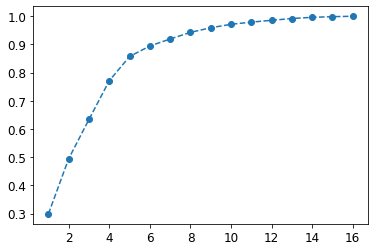

In [51]:
# Check out the cumulative variance distribution
plt.plot(range(1, 17), pca.explained_variance_ratio_.cumsum(), marker = "o", linestyle = "--"); plt.show()

In [52]:
# About 80% of variance is captured in the first 4 components
# Train another pca this time specifying 4 principal components
pca = PCA(n_components = 4)
pca.fit(clustarray)

PCA(n_components=4)

In [53]:
# Save the pca values in a their own array
scores = pca.transform(clustarray)

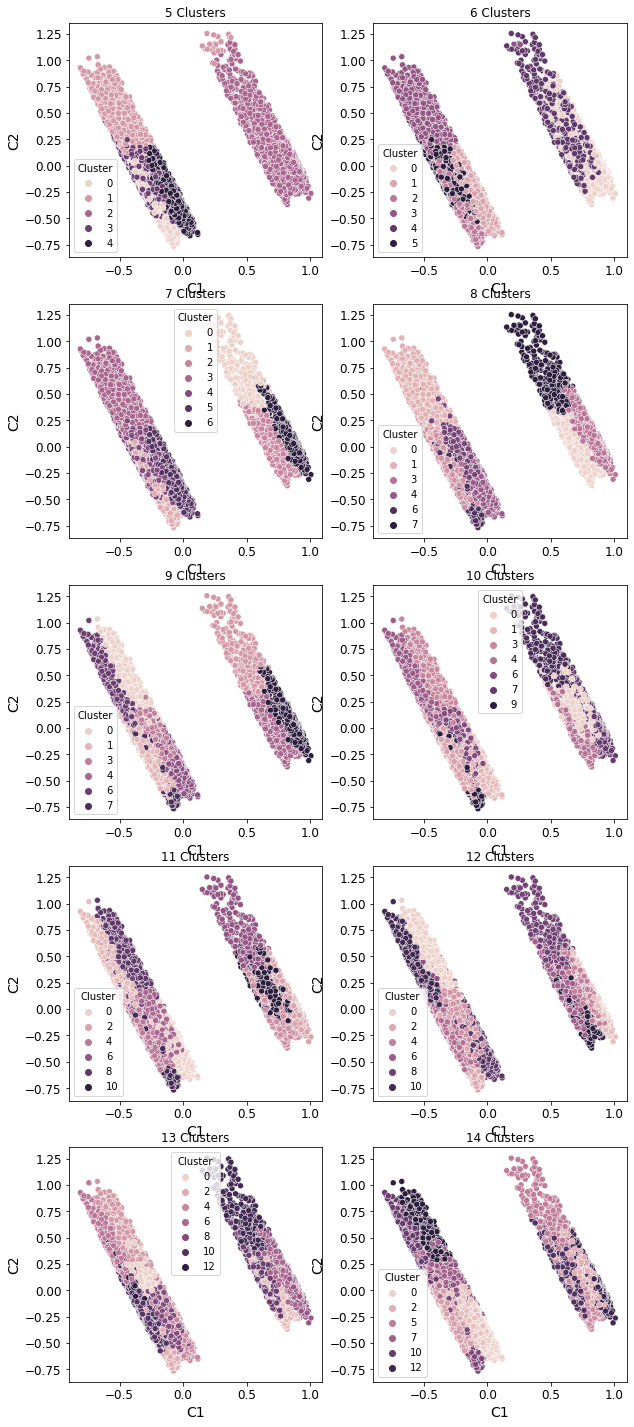

In [58]:
# Try out various numbers of clusters for a kmeans algorithm and visualize the results
# https://365datascience.com/tutorials/python-tutorials/pca-k-means/

# Trying out k values 5 - 14 so set the grid to 2 rows by 5 columns
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (10, 25))

# Create a nested list which holds values that will be referenced in the loop
parameters = [[5, 0, 0], [6, 0, 1], [7, 1, 0], [8, 1, 1], [9, 2, 0],        # Clusters k = 5 through k = 9
              [10, 2, 1], [11, 3, 0], [12, 3, 1], [13, 4, 0], [14, 4, 1]]   # Clusters k = 10 through k = 14


# Loop through each list, perform the kmeans, and plot the result
for plist in parameters:

    # Save the number of k, the row position, and the column position
    numberk = plist[0]; rowpos = plist[1]; colpos = plist[2]

    # Perform the kmeans algorithm with the specified value for k
    kmeans = KMeans(n_clusters = numberk, random_state = 42)
    kmeans.fit(scores)

    # Put all the results in a dataframe with named columns
    audiodf = pandas.DataFrame(clustarray, columns = clustfeats)    # Put the audio features in a df
    columns = ["C" + str(number) for number in range(1, 5)]         # Save the column names for the pca components
    components = pandas.DataFrame(scores, columns = columns)        # Put the pca components in a df
    clustdf = pandas.concat([audiodf, components], axis = 1)        # Cbind the dataframes together
    clustdf["Cluster"] = kmeans.labels_                             # Add the clusters as a column

    # Save the title of the plot
    title = str(numberk) + " Clusters"

    # Create a 2d visual with the first 2 principal components
    sns.scatterplot(ax = axes[rowpos, colpos], x = clustdf["C1"], y = clustdf["C2"], hue = clustdf["Cluster"]).set(title = title)

In [59]:
# Retrain the knn model with 7 clusters
kmeans = KMeans(n_clusters = 7, random_state = 42)
kmeans.fit(scores)

KMeans(n_clusters=7, random_state=42)

In [60]:
# Add the kmeans clusters for each song as a column to the dataframe
song["Cluster"] = kmeans.labels_

<p>&nbsp;</p>

<font size = "5">

I experimented with different numbers of clusters from 5 clusters to 14 clusters (10 different number of clusters). While 5 clusters seems a bit on the low side, and 15 clusters seems a bit on the high side, I wanted to see how everything looked in this range. The chart can be read from left to right and top to bottom. So, starting at the top left is the clustering result using 5 clusters, the one to the right of that is the clustering result using 6 clusters, and so on and so forth.

The clusters are very well distinguished from eachother in the beginning. Around k = 8, you can start to see that there is some blending happening. K = 7 seems to be the best option, since it is the highest number while still maintaining clearly distinct clusters. 7 clusters might be a little bit on the low side. And I don't neccessarily think that a little bit of blending is a bad thing, since it is probably realistic to think that there is some crossover between song clusters, but nonetheless, I am going to move forward with the 7 clusters.

<p>&nbsp;</p>

In [95]:
# Define a function for printing out a song
def printsong(songdataframe, popularityrank, clusternumber):
    print("Popular Song #" + str(popularityrank + 1) + " in Cluster ", str(clusternumber), "\n")
    print("SongName: ", list(songdataframe.SongName)[popularityrank])
    print("ArtistName: ", list(songdataframe.ArtistName)[popularityrank])
    print("Popularity: ", list(songdataframe.Popularity)[popularityrank])
    print("Sentiment: ", list(songdataframe.Sentiment)[popularityrank])
    print("Tempo: ", list(songdataframe.Tempo)[popularityrank])
    print("ReleaseYear: ", list(songdataframe.Year)[popularityrank], "\n")

In [96]:
# Print out the 5 most popular songs from the first cluster
temp = song[song.Cluster == 0].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 1)
printsong(temp, 1, 1)
printsong(temp, 2, 1)
printsong(temp, 3, 1)
printsong(temp, 4, 1)

Popular Song #1 in Cluster  1 

SongName:  In The Bible (with Lil Durk & Giveon)
ArtistName:  Drake
Popularity:  82
Sentiment:  0.14797077922077922
Tempo:  143.07
ReleaseYear:  2021 

Popular Song #2 in Cluster  1 

SongName:  Astronomy
ArtistName:  Conan Gray
Popularity:  78
Sentiment:  -0.32820512820512815
Tempo:  145.252
ReleaseYear:  2021 

Popular Song #3 in Cluster  1 

SongName:  Depression & Obsession
ArtistName:  XXXTENTACION
Popularity:  73
Sentiment:  0.020000000000000004
Tempo:  105.95
ReleaseYear:  2017 

Popular Song #4 in Cluster  1 

SongName:  First Day of My Life
ArtistName:  Bright Eyes
Popularity:  71
Sentiment:  0.18235294117647055
Tempo:  95.162
ReleaseYear:  2005 

Popular Song #5 in Cluster  1 

SongName:  No Idea - Dj Purpberry Chopped and Screwed
ArtistName:  Don Toliver
Popularity:  69
Sentiment:  0.10456885456885456
Tempo:  99.891
ReleaseYear:  2019 



<p>&nbsp;</p>

<font size = "5">

This genre seems to be a hip hop / rap cluster, with the exception of song #2 and song #4.

<p>&nbsp;</p>

In [97]:
# Print out the 5 most popular songs from the second cluster
temp = song[song.Cluster == 1].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 2)
printsong(temp, 1, 2)
printsong(temp, 2, 2)
printsong(temp, 3, 2)
printsong(temp, 4, 2)

Popular Song #1 in Cluster  2 

SongName:  I WANNA BE YOUR SLAVE
ArtistName:  Måneskin
Popularity:  90
Sentiment:  0.07965686274509803
Tempo:  132.507
ReleaseYear:  2021 

Popular Song #2 in Cluster  2 

SongName:  Livin' On A Prayer
ArtistName:  Bon Jovi
Popularity:  84
Sentiment:  0.23075778388278392
Tempo:  122.511
ReleaseYear:  1986 

Popular Song #3 in Cluster  2 

SongName:  No Friends In The Industry
ArtistName:  Drake
Popularity:  82
Sentiment:  -0.0037403865975294596
Tempo:  83.737
ReleaseYear:  2021 

Popular Song #4 in Cluster  2 

SongName:  august
ArtistName:  Taylor Swift
Popularity:  81
Sentiment:  0.09365079365079364
Tempo:  89.937
ReleaseYear:  2020 

Popular Song #5 in Cluster  2 

SongName:  affection
ArtistName:  BETWEEN FRIENDS
Popularity:  76
Sentiment:  0.016666666666666653
Tempo:  179.518
ReleaseYear:  2018 



<p>&nbsp;</p>

<font size = "5">

This cluster seems to be a pop like cluster, with positive sounding songs.

<p>&nbsp;</p>

In [98]:
# Print out the 5 most popular songs from the third cluster
temp = song[song.Cluster == 2].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 3)
printsong(temp, 1, 3)
printsong(temp, 2, 3)
printsong(temp, 3, 3)
printsong(temp, 4, 3)

Popular Song #1 in Cluster  3 

SongName:  Little Bit of Love
ArtistName:  Tom Grennan
Popularity:  78
Sentiment:  0.09542147042147042
Tempo:  106.52
ReleaseYear:  2021 

Popular Song #2 in Cluster  3 

SongName:  ILoveUIHateU
ArtistName:  Playboi Carti
Popularity:  77
Sentiment:  0.0533040027605245
Tempo:  134.988
ReleaseYear:  2020 

Popular Song #3 in Cluster  3 

SongName:  CITY OF ANGELS
ArtistName:  24kGoldn
Popularity:  77
Sentiment:  0.04375308641975308
Tempo:  120.082
ReleaseYear:  2019 

Popular Song #4 in Cluster  3 

SongName:  International Love (feat. Chris Brown)
ArtistName:  Pitbull
Popularity:  76
Sentiment:  -0.07525252525252521
Tempo:  120.05
ReleaseYear:  2011 

Popular Song #5 in Cluster  3 

SongName:  Good as Hell
ArtistName:  Lizzo
Popularity:  75
Sentiment:  -0.19772727272727272
Tempo:  95.982
ReleaseYear:  2019 



<p>&nbsp;</p>

<font size = "5">

This cluster feels like another pop like cluster, with upbeat songs.

<p>&nbsp;</p>

In [99]:
# Print out the 5 most popular songs from the fourth cluster
temp = song[song.Cluster == 3].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 4)
printsong(temp, 1, 4)
printsong(temp, 2, 4)
printsong(temp, 3, 4)
printsong(temp, 4, 4)

Popular Song #1 in Cluster  4 

SongName:  The Joker And The Queen
ArtistName:  Ed Sheeran
Popularity:  78
Sentiment:  0.2147058823529412
Tempo:  134.019
ReleaseYear:  2021 

Popular Song #2 in Cluster  4 

SongName:  It's Beginning to Look a Lot like Christmas
ArtistName:  Michael Bublé
Popularity:  77
Sentiment:  0.24441964285714288
Tempo:  94.775
ReleaseYear:  2011 

Popular Song #3 in Cluster  4 

SongName:  Fall in Love with You.
ArtistName:  Montell Fish
Popularity:  77
Sentiment:  0.06608476064997804
Tempo:  73.984
ReleaseYear:  2021 

Popular Song #4 in Cluster  4 

SongName:  if u could see me cryin' in my room
ArtistName:  Arash Buana
Popularity:  75
Sentiment:  -0.035
Tempo:  140.323
ReleaseYear:  2020 

Popular Song #5 in Cluster  4 

SongName:  Paris in the Rain
ArtistName:  Lauv
Popularity:  74
Sentiment:  -0.09373522458628843
Tempo:  76.309
ReleaseYear:  2018 



<p>&nbsp;</p>

<font size = "5">

This cluster feels like an alternative / pop cluster with slower and mellower sounding songs.

<p>&nbsp;</p>

In [100]:
# Print out the 5 most popular songs from the fifth cluster
temp = song[song.Cluster == 4].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 5)
printsong(temp, 1, 5)
printsong(temp, 2, 5)
printsong(temp, 3, 5)
printsong(temp, 4, 5)

Popular Song #1 in Cluster  5 

SongName:  I Touch Myself
ArtistName:  Divinyls
Popularity:  65
Sentiment:  0.0
Tempo:  109.328
ReleaseYear:  1991 

Popular Song #2 in Cluster  5 

SongName:  You Can Get It If You Really Want
ArtistName:  Jimmy Cliff
Popularity:  64
Sentiment:  0.30972222222222223
Tempo:  128.171
ReleaseYear:  1972 

Popular Song #3 in Cluster  5 

SongName:  Let's Get It On
ArtistName:  Marvin Gaye
Popularity:  62
Sentiment:  0.029166666666666664
Tempo:  168.512
ReleaseYear:  1973 

Popular Song #4 in Cluster  5 

SongName:  The Ballad Of Curtis Loew
ArtistName:  Lynyrd Skynyrd
Popularity:  62
Sentiment:  -0.03410052910052909
Tempo:  144.821
ReleaseYear:  1974 

Popular Song #5 in Cluster  5 

SongName:  The First Cut Is the Deepest
ArtistName:  Rod Stewart
Popularity:  62
Sentiment:  -0.04406817342863856
Tempo:  81.278
ReleaseYear:  1976 



<p>&nbsp;</p>

<font size = "5">

This cluster consists of mainly oldies like songs.

<p>&nbsp;</p>

In [101]:
# Print out the 5 most popular songs from the sixth cluster
temp = song[song.Cluster == 5].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 6)
printsong(temp, 1, 6)
printsong(temp, 2, 6)
printsong(temp, 3, 6)
printsong(temp, 4, 6)

Popular Song #1 in Cluster  6 

SongName:  IDGAF
ArtistName:  Dua Lipa
Popularity:  80
Sentiment:  0.11142857142857145
Tempo:  97.028
ReleaseYear:  2017 

Popular Song #2 in Cluster  6 

SongName:  Own Brand Freestyle
ArtistName:  FelixThe1st
Popularity:  80
Sentiment:  0.1343394886363636
Tempo:  128.068
ReleaseYear:  2021 

Popular Song #3 in Cluster  6 

SongName:  all I want is you
ArtistName:  Rebzyyx
Popularity:  77
Sentiment:  0.12037037037037036
Tempo:  145.911
ReleaseYear:  2021 

Popular Song #4 in Cluster  6 

SongName:  Jenny (I Wanna Ruin Our Friendship)
ArtistName:  Studio Killers
Popularity:  75
Sentiment:  0.17500000000000002
Tempo:  133.928
ReleaseYear:  2020 

Popular Song #5 in Cluster  6 

SongName:  Kiss and Make Up
ArtistName:  Dua Lipa
Popularity:  75
Sentiment:  -0.22857142857142856
Tempo:  99.895
ReleaseYear:  2018 



<p>&nbsp;</p>

<font size = "5">

This cluster looks like songs that are about relationships and are maybe sound a little bit softer.

<p>&nbsp;</p>

In [102]:
# Print out the 5 most popular songs from the sixth cluster
temp = song[song.Cluster == 6].sort_values(by = "Popularity", ascending = False, axis = 0)
printsong(temp, 0, 7)
printsong(temp, 1, 7)
printsong(temp, 2, 7)
printsong(temp, 3, 7)
printsong(temp, 4, 7)

Popular Song #1 in Cluster  7 

SongName:  Overpass Graffiti
ArtistName:  Ed Sheeran
Popularity:  90
Sentiment:  -0.1437869822485207
Tempo:  175.908
ReleaseYear:  2021 

Popular Song #2 in Cluster  7 

SongName:  Love Again
ArtistName:  Dua Lipa
Popularity:  79
Sentiment:  -0.19301503094606548
Tempo:  115.982
ReleaseYear:  2021 

Popular Song #3 in Cluster  7 

SongName:  TALES OF DOMINICA
ArtistName:  Lil Nas X
Popularity:  77
Sentiment:  -0.033333333333333326
Tempo:  114.952
ReleaseYear:  2021 

Popular Song #4 in Cluster  7 

SongName:  Pissed Me Off
ArtistName:  Lil Durk
Popularity:  76
Sentiment:  0.025006775067750675
Tempo:  155.967
ReleaseYear:  2021 

Popular Song #5 in Cluster  7 

SongName:  Up And Down
ArtistName:  Doja Cat
Popularity:  75
Sentiment:  -0.0027218152218152305
Tempo:  74.979
ReleaseYear:  2021 



<p>&nbsp;</p>

<font size = "5">

This cluster looks like songs that are about relationships but maybe sound a little bit stronger.

<p>&nbsp;</p>

### **Conclusion**

<font size = "5">

The clusters are quite as unique as I was hoping they would be, but it is apparent that the clustering algorithm was able to find some patterns in the data! I attribute this to the combination of the audio features (how the song sounds), the topics (what the song is about), the sentiment (is the song happy or sad), as well as when the song was released and the duration of the song. I feel as though these cover the main aspects of what makes up a song.

Unfortunately, the ambiguity when it comes to song data is a difficult challenge to deal with. Some of the lingering questions that I have are, how good are the audio features that Spotify provides? Could I have done a better job of cleaning up the song lyrics? Could I have done a better job of topic modeling? Did I include too many features that may have caused confusion during clustering?

If I had more time, I would love to continue analyzing this data and tweaking and tuning the data that goes into the clustering algorithm, but I spent the majority of my time on the data collection process. I do not regret this at all, however, because I learned a ton from going through that processs. It is just that due to the time constraints of this project, this did not leave me with a ton of time to really fine tune the other parts of the project.

<p>&nbsp;</p>